# Artificial „SU(3) quarks” in quantum dots
This notebook contain code for initialization: layout, Hamiltonian (from Layout), and diagonalization of Hamiltonian


In [18]:
# import necesary modules
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

Set necesary constants for initialization of layout and Hailtonian

In [19]:
# layout_size_x = 2   # number of atoms in X axis
# layout_size_y = 2   # number of atoms in Y axis

# constants
hbar = scipy.constants.hbar
h = scipy.constants.h
pi = math.pi
m_0 = scipy.constants.physical_constants["atomic unit of mass"][0]
_1eV  = scipy.constants.physical_constants["electron volt"][0]
# ax = 5 # [Angstrom] or [nm]

# t = 0.2               # parameter of Hamiltonian
#t = 0.056865404718729244
a = 1 #[nm]
r_0 = 10 #[nm]
V_max = 0.3 #[eV]

m_eff = 0.067 # [* m_0]
E0 = 0
t = 1 / (2 * m_eff * a ** 2) * (hbar ** 2) / (m_0 * 10e-20 * _1eV)   # [eV]

Functions for initialization layout and ploting it

In [20]:
def initialize_layout(layout_size_x, layout_size_y):
    Layout = np.zeros((layout_size_y, layout_size_x), dtype=int)
    k = 1
    for i in range(layout_size_x):
        for j in range(layout_size_y):
            Layout[j][i] = k
            k += 1
    return Layout

In [21]:
def plot_layout(Layout):
    x = Layout.shape[1]
    y = Layout.shape[0]
    X = np.arange(1, x+1, 1, dtype=int)
    fig, axs = plt.subplots(1, 1)

    for i in range(y):
        Y=[]
        for j in range(x):
            Y.append(i+1)
        axs.scatter(X, Y, c='blue', linewidths=10)
    axs.set_aspect('equal', 'box')
    formatter = mticker.ScalarFormatter()
    axs.xaxis.set_major_formatter(formatter)
    axs.xaxis.set_major_locator(mticker.FixedLocator([]))
    axs.yaxis.set_major_locator(mticker.FixedLocator([]))
    plt.show()

Function for initialization Hamiltonian fr0m layout

In [29]:
def initialize_hamiltonian(Layout, t):
    elements = Layout.shape[0]*Layout.shape[1]
    layout_size_x = Layout.shape[0]
    layout_size_y = Layout.shape[1]
    Hamiltonian = np.zeros((elements,elements))

    for i in range(layout_size_x):
        for j in range(layout_size_y):
            elem = Layout[i,j] - 1
            #print("elem = ",Layout[i,j], i, j)
            #print("neghbours: ")
            next_x, prev_x, next_y, prev_y = neighbours(Layout, i, j, True)
            #print(next_x, prev_x, next_y, prev_y)
            Hamiltonian[next_x,elem] = -t
            Hamiltonian[prev_x,elem] = -t
            Hamiltonian[next_y,elem] = -t
            Hamiltonian[prev_y,elem] = -t
            # symetria
            Hamiltonian[elem,next_x] = -t
            Hamiltonian[elem,prev_x] = -t
            Hamiltonian[elem,next_y] = -t
            Hamiltonian[elem,prev_y] = -t

    for i in range(elements):
       #  Hamiltonian[i][i] = 4*t - V_max/r_0**2 * distance_from_center(i+1, layout_size_x, Layout, a) - V_max
       Hamiltonian[i][i] = 4*t + V(i, layout_size_x, Layout, a)
       
    return Hamiltonian

def V(i, layout_size_x, Layout, a):
    dist = distance_from_center(i+1, layout_size_x, Layout, a)
    if dist >= r_0:
        return 0 
    else:
        return - V_max/(r_0*r_0) * dist* dist - V_max

def V_n_direct(dist):
    dist = abs(dist)
    if np.sqrt(dist) >= r_0:
        return 0
    else:
        return V_max/(r_0*r_0) * dist - V_max

def V_n(dist):
    a_help = np.zeros_like(dist)
    for i in range(len(dist)):
        a_help[i] = V_n_direct(dist[i])
    return a_help

def distance(elem1, elem2, Layout, a):
    x1, y1 = find_coordinates(elem1, Layout)
    x2, y2 = find_coordinates(elem2, Layout)
    #print(x1, x2, y1, y2)
    return (a*(x1-x2))**2 + (a*(y1-y2))**2

def distance_from_center(elem1, size_dim, Layout, a):
    center = (size_dim-1)/2
    #print("center = ",center)
    x1, y1 = find_coordinates(elem1, Layout)
    #print(elem1, " -> ", (a*(x1 - center))**2 + (a*(y1 - center))**2)
    return math.sqrt((a*(x1 - center))**2 + (a*(y1 - center))**2)

def find_coordinates(elem, Layout):
    layout_size_x = Layout.shape[0]
    layout_size_y = Layout.shape[1]

    for i in range(layout_size_x):
        for j in range(layout_size_y):
            if Layout[i,j] == elem:
                return i, j
    return -1, -1


def neighbours(Layout, i, j, PBC:bool):
    layout_size_x = Layout.shape[0]
    layout_size_y = Layout.shape[1]
    if PBC:
        #if j = layout_size_y-1:
        
        if j in range(1,layout_size_y-1):
            next_y = j + 1
            prev_y = j - 1
        elif j == 0:
            next_y = j + 1
            prev_y = layout_size_y-1
        else:
            next_y = 0
            prev_y = j - 1

        if i in range(1,layout_size_x-1):
            next_x = i + 1
            prev_x = i - 1
        elif i == 0:
            next_x = i + 1
            prev_x = layout_size_x-1
        else:
            next_x = 0
            prev_x = i - 1
    else:
        pass
    
    '''print(Layout[next_x,j],
          Layout[prev_x,j],
          Layout[i,next_y],
          Layout[i,prev_y])'''
    # print(next_x, prev_x, next_y, prev_y)
    return Layout[i,prev_y]-1, Layout[i,next_y]-1,Layout[prev_x,j]-1,Layout[next_x,j]-1 
    # return next_x, prev_x, next_y, prev_y
        

Function for diagonalization

In [23]:
'''def diagonalize_hamiltonian(Hamiltonian):
    w,v =  np.linalg.eig(Hamiltonian)
    idx = w.argsort()
    w = w[idx]
    v = v[:,idx]
    diagonal = np.diag(w)
    print("\nwartosci wlasne:\n", w)
    # print("\nwektory wlasne:\n", v)
    # print('\nZdiagonalizowany Hamiltonian:\n', diagonal)
    plt.plot(w[0:15], 'o')
    plt.show()
    return diagonal'''

def diagonalize_hamiltonian(Hamiltonian):
    E,psiT = np.linalg.eigh(Hamiltonian) # This computes the eigen values and eigenvectors
    psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
    #plt.plot(E, 'o')
    #plt.show()
    return E


## Let's show how layout look like:

## Let's show how Hamiltonian look like:

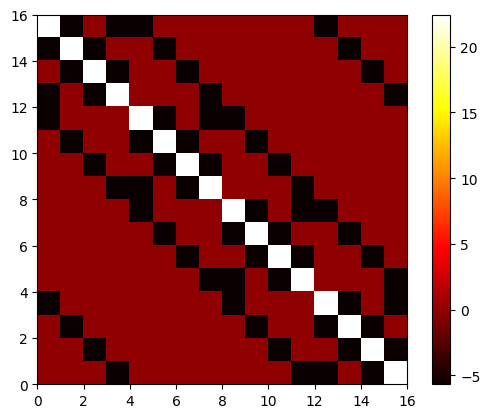

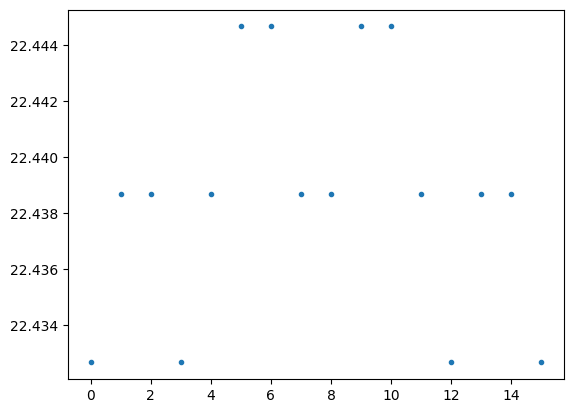

In [30]:
N = 4
Layout = initialize_layout(N, N)
Hamiltonian = initialize_hamiltonian(Layout, t)
#print(Hamiltonian)
#Hamiltonian = np.flip(Hamiltonian,axis=1)
ran = math.floor(math.sqrt(Hamiltonian.size))
plt.imshow(Hamiltonian, cmap='hot', extent=[0, ran, 0, ran])

#print(ran)
'''
for i in range(ran): 
    for j in range(ran): 
        plt.annotate(str(f'{Hamiltonian[i][j]:.3}'), xy=(j+0.5, i+0.5), 
                     ha='center', va='center', color='white') 
'''
plt.colorbar() 
plt.show()
aaa = np.zeros(ran)
for i in range(ran):
    aaa[i] = Hamiltonian[i][i]
plt.clf()
plt.plot(aaa, ".")
plt.show()

In [9]:
import pandas as pd 

In [10]:
print(type(Hamiltonian))
df = pd.DataFrame(Hamiltonian)
df.to_csv("Desktop.csv" ,index=False, header=False)

<class 'numpy.ndarray'>


## Let's show how Hamiltonian look like after diagonalization:

In [11]:
diagonalizated_hamiltonain = diagonalize_hamiltonian(Hamiltonian)

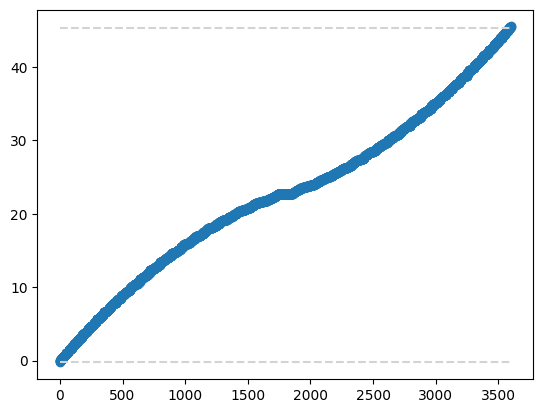

In [12]:
N = 60
Layout = initialize_layout(N, N)
#print(Layout)
#plot_layout(Layout)
Hamiltonian = initialize_hamiltonian(Layout, t)
#Hamiltonian = np.flip(Hamiltonian,axis=1)
#print(Hamiltonian)
diagonalizated_hamiltonain = diagonalize_hamiltonian(Hamiltonian)
plt.plot(diagonalizated_hamiltonain, 'o')
bottom = np.amin(diagonalizated_hamiltonain)
plt.hlines(8*t+bottom, 0, len(diagonalizated_hamiltonain), colors="lightgray", linestyles="--")
plt.hlines(bottom, 0, len(diagonalizated_hamiltonain), colors="lightgray", linestyles="--")
plt.show()

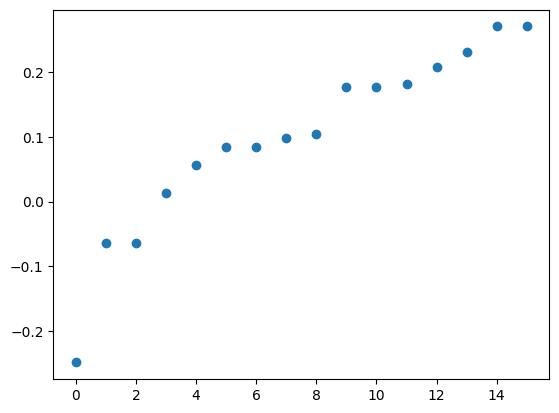

In [13]:
plt.plot(diagonalizated_hamiltonain[:16], 'o')

# test potential

In [14]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

10000


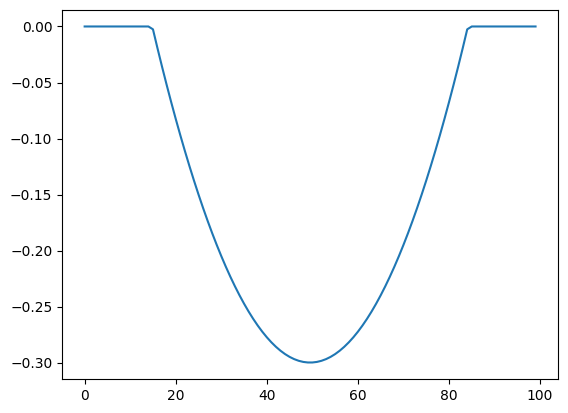

<Figure size 640x480 with 0 Axes>

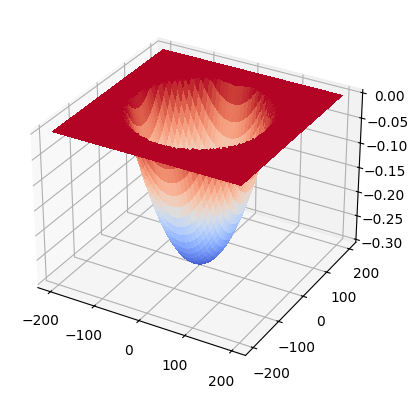

In [15]:
def initialize_V(Layout, t):
    elements = Layout.shape[0]*Layout.shape[1]
    layout_size_x = Layout.shape[0]
    layout_size_y = Layout.shape[1]
    Hamiltonian = np.zeros((elements,elements))

    for i in range(elements):
       #  Hamiltonian[i][i] = 4*t - V_max/r_0**2 * distance_from_center(i+1, layout_size_x, Layout, a) - V_max
       Hamiltonian[i][i] = V(i, layout_size_x, Layout, a)
       #print(Hamiltonian[i][i])
       
    return Hamiltonian

def V_n_direct(dist):
    dist = abs(dist)
    if np.sqrt(dist) >= r_0:
        return 0
    else:
        return V_max/(r_0*r_0) * dist - V_max

def V_n(dist):
    a_help = np.zeros_like(dist)
    for i in range(len(dist)):
        a_help[i] = V_n_direct(dist[i])
    return a_help

a = 2
r_0 = 280
N = 100
Layout = initialize_layout(N, N)
x = np.linspace(-N*a,N*a,N)
y = np.linspace(-N*a,N*a,N) 
#x = np.arange(-5, 5, 0.25)
#y = np.arange(-5, 5, 0.25)

xx, yy = np.meshgrid(x, y)

R = ((a*xx)**2 + (a*yy)**2)
#print(R[math.floor(len(R)/2)])
#Z = np.sin(R)

f = lambda R: V_n(R)
#f = lambda x, y: 2*V_max/(r_0*r_0) * np.sqrt((a*x)**2 + (a*y)**2) - V_max
#f = lambda x, y: np.sqrt((a*x)**2 + (a*y)**2)
Potencial = np.array(list(map(f, R)))

print(Potencial.size)
plt.plot(Potencial[math.floor(len(Potencial)/2)])
plt.show()
plt.clf()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(xx, yy, Potencial, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


0


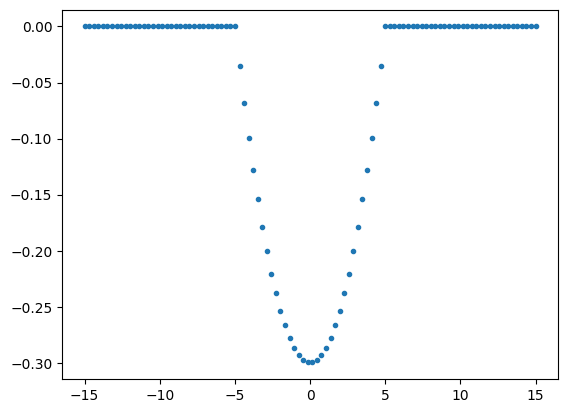

In [16]:
a = 1
r_0 = 5
V_max = 0.3

def V_n_direct(dist):
    dist = abs(dist)
    if dist >= r_0:
        return 0
    else:
        return V_max/(r_0*r_0) * dist * dist - V_max
    
print(V_n_direct(-15))
a = np.linspace(-15,15,100)
f = lambda R: V_n_direct(R)
b = np.array(list(map(f, a)))
plt.plot(a,b,'.')
plt.show()